<a href="https://colab.research.google.com/github/ACTCollaboration/DR6_Notebooks/blob/main/ACT_DR6_lensing_transfer_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating the ACT Lensing Transfer Function

*Written by Joshua Kim and the ACT collaboration*

---

This notebook will demonstrate how we generate the lensing transfer function for the ACT Data Release 6 (DR6) analyses. In order to extract cosmological information from CMB lensing maps we compute the lensing power spectrum. Once we have this spectrum, it's important to correctly calibrate it in order to account for any biases. This calibration is done by testing our pipeline on simulations and then generating a multiplicative transfer function which is then used in conjunction with the biased spectrum in order to recover the "true" power spectrum.

In order to compute this transfer function we rely on realistic simulations of the ACT lensing maps. For the actual analysis we use 400 simulations, however, due to the limitations of working in a notebook we have simplified the analysis by using only a handful of simulations. For anyone who wishes to recreate the full transfer function we suggest moving this code to a cluster and running it with the full suite of sims.


The data for this release is publicly available on [Lambda](https://lambda.gsfc.nasa.gov/product/act/actadv_prod_table.html) and a full discussion of the ACT DR6 lensing analysis can be found in [Qu et al. (2023) ](https://arxiv.org/abs/2304.05202), [Madhavacheril et al. (2023)](https://arxiv.org/abs/2304.05203), [MacCrann et al. (2023)](https://arxiv.org/abs/2304.05196) and [Farren et al. (2023)](https://arxiv.org/abs/2309.05659).

The pipeline presented below relies on a number of other packages including [`healpy`](https://healpy.readthedocs.io/en/latest/), [`pixell`](https://pixell.readthedocs.io/en/latest/) and [`NaMaster`](https://arxiv.org/abs/1809.09603) and we encourage users to refer to the relevant documentation as needed.

For anyone who would like a bit more background in CMB analysis we recommend a few other resources from ACT at the end of this notebook.

### Run ONCE only

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install() # expect a kernel restart

✨🍰✨ Everything looks OK!


A kernel restart is *expected* if the condacolab cell runs successfully. Proceed by testing the install with the next cell!

In [3]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


# Data Products

We need the following:

*   Some secondary mask (e.g. from a galaxy survey of choice)
*   ACT DR6 lensing analysis mask
*   Simulations of ACT DR6 lensing reconstructions
*   Input lensing potentials used to create the simulations mentioned above


The first two are easiest to use in `healpix` format (make sure they have the same `Nside` resolution!), but can be converted from `pixell` formats using the `pixell.reproject` module. The latter two are most commonly formatted as spherical harmonic transform coefficients, commonly known as `alms`.


We'll start by downloading the neccesary data, this might take a bit of time.
This specific example of the galaxy mask used here is discussed in [DES Collaboration (2021)](https://arxiv.org/abs/2107.04646).

In [6]:
%%capture
# sims
!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/maps/baseline/simulations/kappa_alm_sim_act_dr6_lensing_v1_baseline_000{1..9}.fits
!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/maps/baseline/simulations/kappa_alm_sim_act_dr6_lensing_v1_baseline_0010.fits
!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/sim_inputs/kappa_alm/input_kappa_alm_sim_000{1..9}.fits
!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/sim_inputs/kappa_alm/input_kappa_alm_sim_0010.fits

# lensing masks
!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/maps/baseline/mask_act_dr6_lensing_v1_healpix_nside_4096_baseline.fits

# galaxy mask
!wget https://desdr-server.ncsa.illinois.edu/despublic/y3a2_files/baosample/DESY3_LSSBAO_MASK_HPIX4096NEST.fits


In [5]:
FILLER = "#"
RECON_SIM_FORMAT = "kappa_alm_sim_act_dr6_lensing_v1_baseline_####.fits"
INPUT_KAPPA_FORMAT = "input_kappa_alm_sim_####.fits"

# Imports

Requires:

*   `numpy`
*   `healpy`
*   `pymaster`
*   `pixell`

This cell can take a few minutes to run as well.

In [7]:
%%capture
!pip install numpy healpy pixell pyfisher

!mamba install -y -c conda-forge namaster

In [8]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, reproject, lensing as plensing, curvedsky as cs

import os, time

import pymaster as nmt

# Constants

These constants set the ell range that will be analyzed, the size of the bin (`LperBin`) and the `NSIDE` of the healpix maps. There are two `LMAX` values here, `LMAX` refers to the maximum ell that the calculation will be performed up to and `LMAX_CUT` is the desired upper bound (more on this later!). Feel free to change these as needed!

Note the number of bandpowers will be `(LMAX_CUT - LMIN) / LperBin`.

In [9]:
LMIN = 40
LMAX = 3000
LMAX_CUT = 1000
LperBin = 30
NSIDE = 1024

### Mask setup / manipulation

Not necessary, but making our masks a bit easier to use for the sake of this tutorial.

fsky (gmask):  0.11590
fsky (kmask):  0.23388
fsky (overlap):  0.10049


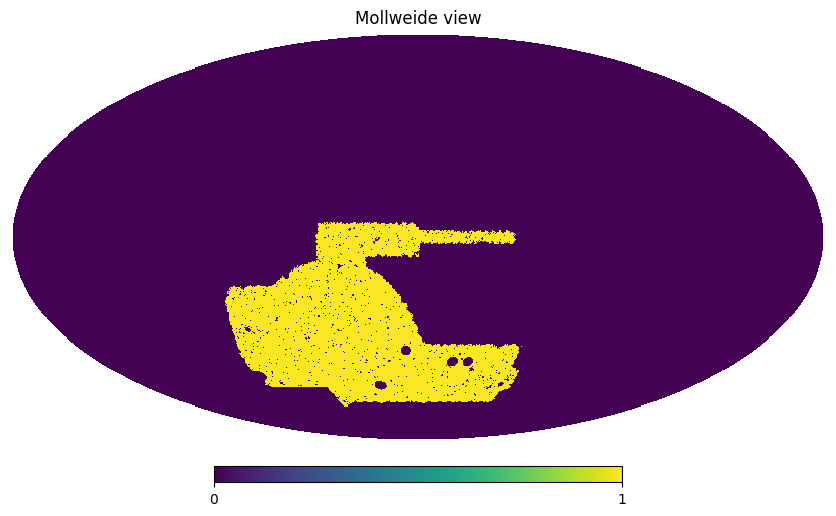

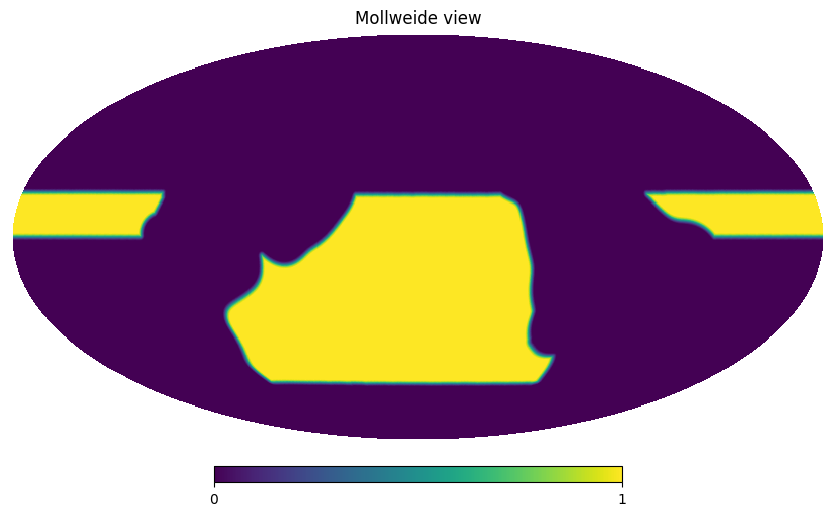

In [10]:
# read in the masks...
GALAXY_MASK = hp.read_map("DESY3_LSSBAO_MASK_HPIX4096NEST.fits")
LENSING_MASK = hp.read_map("mask_act_dr6_lensing_v1_healpix_nside_4096_baseline.fits")
# downgrade it to a more sensible resolution for our purposes...
GALAXY_MASK = hp.ud_grade(GALAXY_MASK, NSIDE)
LENSING_MASK = hp.ud_grade(LENSING_MASK, NSIDE)
# and then make it binary for a simplified calculation.
GALAXY_MASK[GALAXY_MASK < 0.3] = 0.
GALAXY_MASK[GALAXY_MASK > 0.3] = 1.

# build enmap versions of these masks for future usage
# don't need these for running the rest of the notebook's cells!

#shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(1.0/60))
#LENSING_MASK_ENMAP = reproject.healpix2map(LENSING_MASK, shape, wcs)
#GALAXY_MASK_ENMAP = reproject.healpix2map(GALAXY_MASK, shape, wcs)

# plot!
hp.mollview(GALAXY_MASK)
print(f"fsky (gmask): {np.sum(GALAXY_MASK) / np.size(GALAXY_MASK) : 0.5f}")
hp.mollview(LENSING_MASK)
print(f"fsky (kmask): {np.sum(LENSING_MASK) / np.size(LENSING_MASK) : 0.5f}")

joint = GALAXY_MASK*LENSING_MASK
print(f"fsky (overlap): {np.sum(joint) / np.size(joint) : 0.5f}")

# Binning (NaMaster)

We'll set up a few functions that will help us bin the spectra later on.

In [11]:
# bin cls according to some scheme encoded in the coupling matrix
def bin_spectra(cls, coupling_matrix_name):
    cls_nmt = np.array([cls])
    try:
        wsp = nmt.NmtWorkspace()
        wsp.read_from(coupling_matrix_name)
        return wsp.decouple_cell(wsp.couple_cell(cls_nmt))[0]
    except RuntimeError:
        return None

def make_bins(nside=NSIDE,LperBin=50,lmin=LMIN,lmax=LMAX):
    ells    = np.arange(lmax,dtype='int32')
    weights = 1. / LperBin * np.ones_like(ells)
    weights[ells<lmin] = 0

    # Now generate the bandpower indices, here by brute force.
    # A -1 means that ell value is not included in any bandpower.
    bpws = np.zeros_like(ells) - 1
    ibin = 0
    while LperBin*(ibin+1)+lmin<lmax:
        bpws[LperBin*ibin+lmin:LperBin*(ibin+1)+lmin] = ibin
        ibin += 1
    # return Nmt binning instance
    return nmt.NmtBin(nside,bpws=bpws,ells=ells,weights=weights)

# return index for max bin index within a cutoff
def max_bin(bin_edges, cutoff):
    return np.argmax(np.nonzero(bin_edges < cutoff)[0]) + 1

# Transfer function computation (with NaMaster)

The commonly defined transfer function, or $T(l)$, is computed here as the following:

$$
T(l) = \dfrac{\dfrac{1}{N} \displaystyle\sum_{\text{sim } i}^{N} \text{NmtBin}\left(C^{\hat{\kappa} X}_{i, NMT} \right)}{\text{NmtBin}\left(C^{\kappa X}_{\text{CAMB}}\right)}
$$

where $X$ refers to either the input lensing convergence $\kappa$ (used to lens the simulations) or a correlated galaxy field $g$ generated by populating a galaxy simulation so that it has the same auto and cross spectra as the provided theory (see `orphics.maps.generate_correlated_alm`).

The denominator is computed according to cosmological parameters used to create the lensing simulations written in a CAMB .ini file to result in a theory spectrum that is binned by NaMaster (by coupling and then decoupling with a mode-coupling cell), and the numerator is computed as a mean over sims of a NaMaster-computed pseudo-Cl between the reconstructed convergence $\hat{\kappa}$ and $X$, ensuring that the binning of the denominator is done exactly the same way as the numerator.

This is what we should *divide* our initial measurement by to correct the data products for any mode-coupling or fractional sky effects that we expect from the simulations.

For this case, we will treat $X = \kappa$.

## Numerator

We have to now iterate over sims and compute the mean pseudo-Cls with the masks passed into NaMaster. In our actual analysis this is done for 400 simulations, however, for the sake of this notebook we have limited the number of sims to save on both disk space and compute time.

Here is the iterating function:

In [12]:
START_INDEX = 1
END_INDEX = 10 # inclusive

!rm -rf nmt_transfer_function_coupling_matrix.fits
COUPLING_MATRIX_NAME = "nmt_transfer_function_coupling_matrix.fits"

# iterate a function "fn" over all sims with some indexing format
# return dict d where d[idx] = fn(sims[idx], idx)
# if is_healpix_map is set to False, assume the sims are alm files
def iterate_over_kappa_sims(fn, sim_start=START_INDEX, sim_end=END_INDEX,
                            common_format="sims_####.fits", formatter="#"):
    data_dict = {}

    for i in range(sim_start, sim_end+1):
        # find appropriate file name for a given file index
        ndigits = common_format.count(formatter)
        filename = common_format.replace(formatter * ndigits, str(i).zfill(ndigits))

        try:
            print(f"Running index #{str(i)}.")
            print(f"Filename: {filename}")
            filedata = np.nan_to_num(hp.read_alm(filename)).astype(np.complex128)
            print("Iterating...")

            fn(filedata, data_dict, i)
            # for memory purposes
            del filedata

        except FileNotFoundError:
            print(f"Could not find {filename}.")
            continue

    return data_dict

And the helper function it needs to iterate:

In [13]:
# now defining the "fn" to be iterated over in the definition above
# "kappa" here refers to the reconstructed kappa sims
def iterator_clkk(kappa, data_dict, idx):
    # the index # "idx" also specifies the input potential filename
    # assuming recon sim index # == input sim index #
    input_kappa_filename = INPUT_KAPPA_FORMAT.replace(FILLER * INPUT_KAPPA_FORMAT.count(FILLER),
                                                      str(idx).zfill(INPUT_KAPPA_FORMAT.count(FILLER)))
    print(f"Input kappa: {input_kappa_filename}")

    # the input alms are lensing convergence values stored as double complex values
    input_kappa = np.nan_to_num(hp.read_alm(input_kappa_filename)).astype(np.complex128)

    # run NaMaster!
    kmask = LENSING_MASK
    gmask = GALAXY_MASK

    kmap = hp.alm2map(input_kappa, NSIDE)
    khat_map = hp.alm2map(kappa, NSIDE)

    # generate NaMaster binning object
    b = make_bins(nside=NSIDE,LperBin=LperBin,lmin=LMIN,lmax=LMAX)

    # The reconstructed lensing sims are made from pre-masked CMB temperature maps,
    # so the quadratic estimator results in a lensing map effectively masked twice by the ACT mask
    field_k_hat = nmt.NmtField(kmask**2, [khat_map], masked_on_input=True)
    # No need to worry about the input lensing fields, since they are generated on the full sky
    field_k = nmt.NmtField(gmask, [kmap], masked_on_input=False)

    # only compute coupling matrix if not pre-computed / saved before
    w = nmt.NmtWorkspace()
    if os.path.isfile(COUPLING_MATRIX_NAME):
        print("Reading coupling matrix from disk.")
        w.read_from(COUPLING_MATRIX_NAME)
    else:
        w.compute_coupling_matrix(field_k, field_k_hat, b)
        print("Writing coupling matrix to disk.")
        w.write_to(COUPLING_MATRIX_NAME)

    # use coupling matrix to generate pseudo-cls
    clkk = w.decouple_cell(nmt.compute_coupled_cell(field_k, field_k_hat))[0]
    nmtells = b.get_effective_ells()

    # only run to desired lmax cut
    data_dict[idx] = clkk[:max_bin(nmtells, LMAX_CUT)]

Now we iterate over the desired number of sims (expect this cell to take a while, of O(30 min). It can take O(hours) for multiple hundreds of sims using much more RAM than this Colab environment offers)

In [14]:
time1 = time.time()
clkk_data = iterate_over_kappa_sims(iterator_clkk, sim_start=START_INDEX, sim_end=END_INDEX,
                                    common_format=RECON_SIM_FORMAT, formatter=FILLER)
print("--")
print(f"Time elapsed: {time.time()-time1:0.5f} seconds")

Running index #1.
Filename: kappa_alm_sim_act_dr6_lensing_v1_baseline_0001.fits
Iterating...
Input kappa: input_kappa_alm_sim_0001.fits
Writing coupling matrix to disk.
Running index #2.
Filename: kappa_alm_sim_act_dr6_lensing_v1_baseline_0002.fits
Iterating...
Input kappa: input_kappa_alm_sim_0002.fits
Reading coupling matrix from disk.
Running index #3.
Filename: kappa_alm_sim_act_dr6_lensing_v1_baseline_0003.fits
Iterating...
Input kappa: input_kappa_alm_sim_0003.fits
Reading coupling matrix from disk.
Running index #4.
Filename: kappa_alm_sim_act_dr6_lensing_v1_baseline_0004.fits
Iterating...
Input kappa: input_kappa_alm_sim_0004.fits
Reading coupling matrix from disk.
Running index #5.
Filename: kappa_alm_sim_act_dr6_lensing_v1_baseline_0005.fits
Iterating...
Input kappa: input_kappa_alm_sim_0005.fits
Reading coupling matrix from disk.
Running index #6.
Filename: kappa_alm_sim_act_dr6_lensing_v1_baseline_0006.fits
Iterating...
Input kappa: input_kappa_alm_sim_0006.fits
Reading cou

## Denominator

The denominator is simply the ACT DR6 lensing auto-spectrum theory prediction binned with `NaMaster`. Both the numerator and denominator will be binned up to a much higher ell (`LMAX`) than the desired limit (`LMAX_CUT`) to prevent power leakage at the smallest considered scales, and then cut at that limiting bin number after all binning is done.

For this purpose, we will use a provided theory prediction of the lensing auto-spectrum instead of computing one ourselves.

In [15]:
!wget https://raw.githubusercontent.com/ACTCollaboration/actsims/master/data/cosmo2017_10K_acc3_lenspotentialCls.dat

--2024-04-17 20:11:06--  https://raw.githubusercontent.com/ACTCollaboration/actsims/master/data/cosmo2017_10K_acc3_lenspotentialCls.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1120001 (1.1M) [text/plain]
Saving to: ‘cosmo2017_10K_acc3_lenspotentialCls.dat’

cosmo2017_10K_acc3_ 100%[===================>]   1.07M  6.56MB/s    in 0.2s    

2024-04-17 20:11:07 (6.56 MB/s) - ‘cosmo2017_10K_acc3_lenspotentialCls.dat’ saved [1120001/1120001]



In [16]:
ells, dr6_lensing_clkk = np.loadtxt("cosmo2017_10K_acc3_lenspotentialCls.dat", usecols=[0,5], unpack=True)
clkk_theory = dr6_lensing_clkk[ells < 3*NSIDE] * np.pi / 2

# usually monopole and dipole of lensing auto-spectrum is set to zero
# if included at all, but needs to be included for binning
clkk_theory = np.append(np.array([0,0]), clkk_theory)

# Now bin with NaMaster. We will reuse "b"!
b = make_bins(nside=NSIDE,LperBin=LperBin,lmin=LMIN,lmax=LMAX)

# cut to LMAX_CUT
clkk_theory_binned = bin_spectra(clkk_theory,
                                 COUPLING_MATRIX_NAME)[:max_bin(b.get_effective_ells(), LMAX_CUT)]

Compute the mean of the sim-based spectrum computation over the sims for the transfer function as well as the scatter via covariance matrix from the sims to estimate error bars for our transfer function measurement:

In [17]:
clkk_sims = np.array([clkk_data[k] for k in clkk_data.keys()])
clkk_mean_sims = np.mean(clkk_sims, axis=0)

# computing error bars (on the mean) from sims covariance
errs = 1/np.sqrt(END_INDEX - START_INDEX + 1) * np.std(clkk_sims / clkk_theory_binned, axis=0)
xfn = clkk_mean_sims / clkk_theory_binned

# Write to disk
ells = b.get_effective_ells()
ells = ells[:max_bin(ells, LMAX_CUT)]
np.savetxt("act-dr6-transfer-function.txt", np.column_stack((ells, xfn, errs)))

## Transfer function calculation (without NaMaster)

The commonly defined transfer function, or $T(l)$, is computed here as the following:

$$
T(l) = \dfrac{\dfrac{1}{N} \displaystyle\sum_{\text{sim } i}^{N} C^{\hat{\kappa} X}_{i}}{C^{\kappa X}_{\text{CAMB}}}
$$

where $X$ refers to either the input lensing convergence $\kappa$ (used to lens the simulations) or a correlated galaxy field $g$ generated by populating a galaxy simulation so that it has the same auto and cross spectra as the provided theory (see `orphics.maps.generate_correlated_alm`). Again, we will treat $X = \kappa$.

The denominator is computed in the exact same way as above, but we no longer use NaMaster to bin the spectra in both the denominator and numerator. To compute the numerator, we first compute the full-sky cross spectrum between the sets of alms:

$$
C^{XY}_l = \dfrac{1}{2l+1} \displaystyle\sum_{m = -l}^l A_{lm} B^*_{lm}
$$

and then utilize an approximation using powers of the $w$-factor to account for the sky fraction excluded by the powers of the analysis mask.

We will not compute this version in the notebook as a $w$-factor that uses multiple powers of different analysis masks is not trivial to compute. However, here are the appropriate functions to compute this $w$-factor for a given `pixell` enmap-formatted mask:

In [18]:
def wfactor(n,mask,sht=True,pmap=None,equal_area=False):
    """
    Approximate correction to an n-point function for the loss of power
    due to the application of a mask.

    from https://github.com/msyriac/orphics/blob/master/orphics/maps.py
    """
    assert mask.ndim==1 or mask.ndim==2
    if pmap is None:
        if equal_area:
            npix = mask.size
            pmap = 4*np.pi / npix if sht else enmap.area(mask.shape,mask.wcs) / npix
        else:
            pmap = enmap.pixsizemap(mask.shape,mask.wcs)
    return np.sum((mask**n)*pmap) /np.pi / 4. if sht else np.sum((mask**n)*pmap) / np.sum(pmap)

def w_n(mask,n=3):
    """compute the wfactor for an n-point function"""
    pmap = enmap.pixsizemap(mask.shape,mask.wcs)
    return wfactor(n,mask,sht=True,pmap=pmap)

# T(l) results and plots

Let's do a quick visualization of the numerator and denominator to see their agreement:

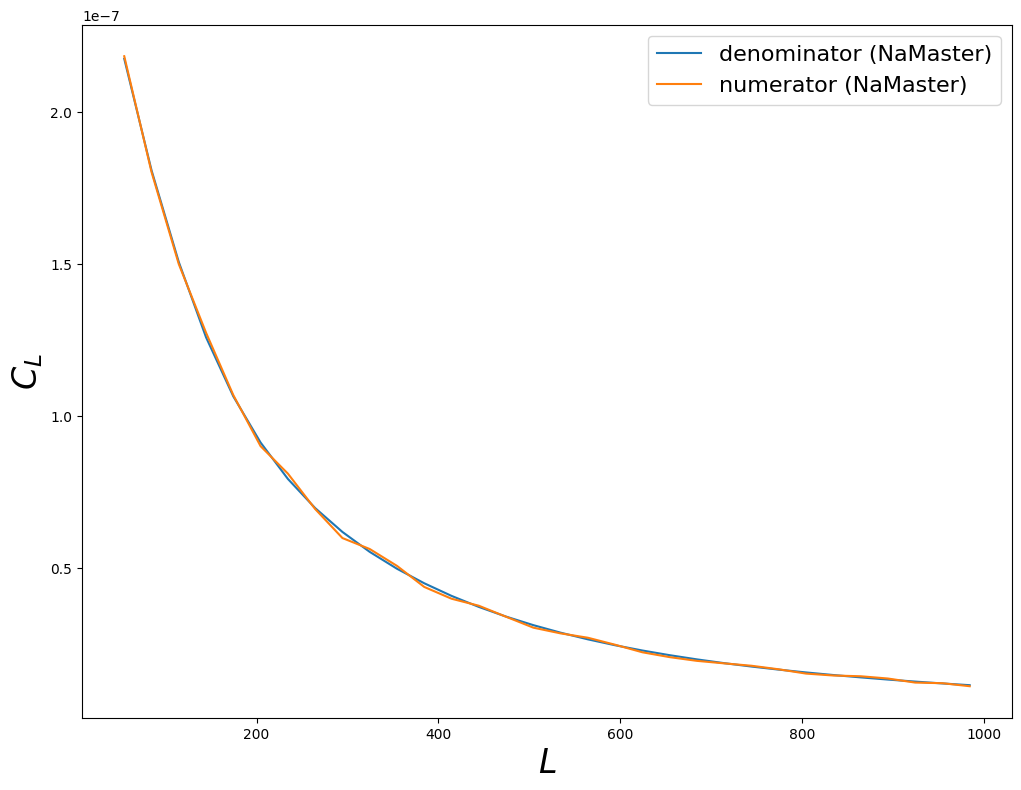

In [19]:
# cut x-axis ells to LMAX_CUT
ells = b.get_effective_ells()
ells = ells[:max_bin(ells, LMAX_CUT)]

plt.figure(figsize=(12,9))
plt.plot(ells, clkk_theory_binned, label="denominator (NaMaster)")
plt.plot(ells, clkk_mean_sims, label="numerator (NaMaster)")
plt.xlabel(r"$L$", size=24)
plt.ylabel(r"$C_L$", size=24)
plt.legend(prop={'size': 16})
plt.show()

Since we can only show 10 cross-correlations of sims, the covariance is very likely to be unconverged and the error bars will blow up; the error on the mean is expected to be smaller and more sensible once a full suite of simulations that have at least $N_{sims} > N_{bandpowers}$ simulations are run.

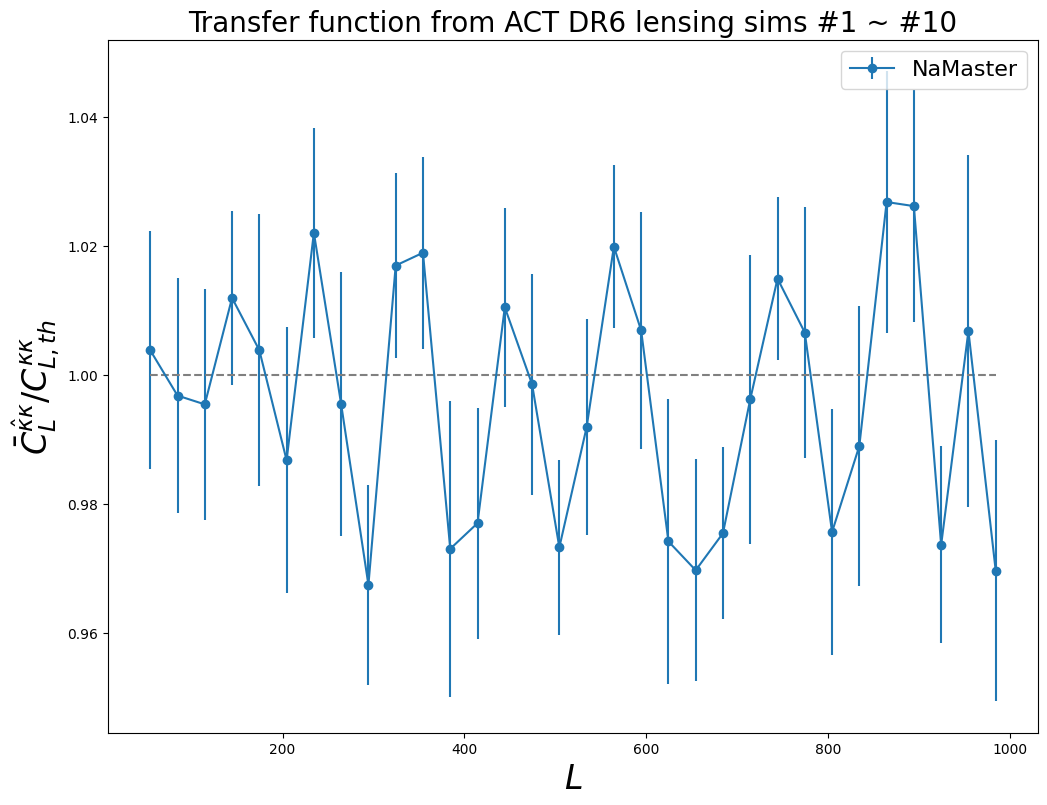

In [20]:
plt.figure(figsize=(12,9))
plt.title(f"Transfer function from ACT DR6 lensing sims #{START_INDEX} ~ #{END_INDEX}", size=20)
plt.errorbar(ells, xfn, errs, fmt='-o', label="NaMaster")
plt.plot(ells, ells * 0. + 1., '--', color='grey')
plt.legend(prop={'size': 16})
plt.xlabel(r"$L$", size=24)
plt.ylabel(r"$\bar{C}_L^{\hat{\kappa} \kappa} / C_{L,th}^{\kappa \kappa}$", size=24)
plt.savefig("act-dr6-transfer-function-plot.png")
plt.show()

It appears as this transfer function is on the order of a few percent and is quite noisy and fluctuating around 1 with no obviously explicit scale dependence. Once again, it is highly recommended to compute the transfer function with more simulations to gain more confidence in the scatter, and once computed, to divide a computed cross-correlation measurement by the bandpowers of this transfer function.

# Related resources:

For more examples of how to use ACT data consider using:
- The DR6 Lensing notebooks available on github
- The DR4 and DR5 ACT notebooks available on [github](https://github.com/ACTCollaboration)
- The `pixell` notebooks which are available on the [`pixell` repo](https://github.com/simonsobs/pixell/tree/master) and describe how to work with maps from ACT